In [3]:
local_path = '../'

"""## Prepare fastai"""
from fastai import *
from fastai.text import *
from fastai.metrics import *
torch.cuda.set_device(2)
np.random.seed(0)
"""## Prepare Dataset"""
local_project_path = local_path + 'data/proteinnet/'
if not os.path.exists(local_project_path):
    os.makedirs(local_project_path)
print('local_project_path:', local_project_path)

local_project_path: ../data/proteinnet/


In [3]:
"""## Tokenization"""
class dna_tokenizer(BaseTokenizer):
    def tokenizer(self, t):
#         return list(t)
        res = []
        tokens = t.split(' ')
        before_seq = tokens[:-2]
        seq = tokens[-2]
        eos = tokens[-1]
        
        res = before_seq
        res += list(seq) # sequence string to list
        res.append(eos)
        
        return res
tokenizer = Tokenizer(tok_func=dna_tokenizer, pre_rules=[], post_rules=[], special_cases=[])
processor = [TokenizeProcessor(tokenizer=tokenizer, include_bos= True, include_eos=True), NumericalizeProcessor(max_vocab=30000)]

In [58]:
df_whole_sprot = pickle.load(open('../data/uniprot_sprot/sproat_parser_df_sp.p', 'rb'))

In [60]:
df_whole_sprot_seq = df_whole_sprot[['sequence']].copy()


In [4]:
train_df_full = pickle.load(open('../data/uniprot_sprot/train_df.p', 'rb'))
train_df = train_df_full[['seq']].copy()
len(train_df)

66840

In [11]:
# bs = 512
# data_lm_protinet = TextLMDataBunch.from_csv(local_project_path, 'test.csv',
#                                    text_cols ='seq', valid_pct= 0.1,
#                                    tokenizer=tokenizer,
#                                    include_bos= True, include_eos=True, bs=bs)

In [61]:
# batch size
bs = 512
# data_lm = (TextList.from_csv(local_project_path, 'test.csv', cols='seq', processor=[OpenFileProcessor(), SPProcessor()])
#                     .split_by_rand_pct(0.01)
#                    .label_for_lm()
#                    .databunch(bs=bs))

# batch size
bs = 512

data_lm = (TextList.from_df(df_whole_sprot_seq, path = local_project_path, cols='sequence', processor=processor)
                   .split_by_rand_pct(0.01)
                   .label_for_lm()
                   .databunch(bs=bs))

In [ ]:
data_lm.vocab.save(local_project_path + 'lm-whole-sp-v2-vocab.pkl')

In [62]:
print('data_cls Training set size', len(data_lm.train_ds))
print('data_cls Validation set size', len(data_lm.valid_ds))

data_cls Training set size 547940
data_cls Validation set size 5534


In [15]:
data_lm.show_batch()

idx,text
0,G K A L L N L F F T L R S S K T P A L S R S L K V F E T F E A K I H H L E T R P C R K P R D S L E G L E Y F V R C E V H L S D V S T L I S S
1,T A C T H C G G R G I V L H G D P I D S A S S N G G R K S D S S G G G G S G G G R R G K R G K K G A A R T E E V H V A K V P D H T P G E H P
2,D C F R Q I V K T Q G V L G L W N G L T A N L L K V V P Y F G V M F S M F E F C K R I F L Y Q N G Y T L S P L T Y K L T P G V D Q S L K P Q
3,C A E Y F N V F L P L I I L N A F E T V A Q E W L S S P N K E N F Y Q L Q L R K F P A D Y K K Y W E F L I Y L N E S E L A K Q L H P K E N D
4,S R xxeos xxbos M V R L A A E L L L L L G L L L L T L H I T V L R G S G A S D R Q D A A A G N N N L N L E S D S T S E T S F P L S K E A P E E H Q V


In [63]:
data_lm.train_ds.x[100]

Text xxbos M S G F R I L D S A G P Q G Q S S Y T W E A K I A Q V Q H D M V A M I N T F N Q Q I A G L S G T I M G R L D Q S V I P K Q Q P P S S A A A I S E S E F E D xxeos

In [64]:
len(data_lm.vocab.itos)

40

In [65]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=1, pretrained=False).to_fp16()

In [ ]:
learn_lm.load('lm-gpu3-sp-40M-v2');

In [20]:
learn_lm.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


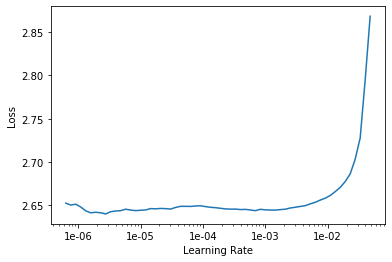

In [26]:
learn_lm.lr_find()
learn_lm.recorder.plot(skip_end = 15)

In [ ]:
# learn_lm.recorder.plot_losses()

In [67]:
lr = 3e-3
learn_lm.unfreeze()
learn_lm.fit_one_cycle(1, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.508514,2.445342,0.247389,11:36


In [68]:
learn_lm.save('lm-whole-sp-v1');
learn_lm.save_encoder('lm-whole-sp-v1-enc');

In [79]:
learn_lm.fit_one_cycle(10, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

In [80]:
learn_lm.save('lm-whole-sp-v4');
learn_lm.save_encoder('lm-whole-sp-v4-enc');

In [ ]:
learn_lm.fit_one_cycle(1, lr, moms=(0.8,0.7))

In [ ]:
# Done

In [78]:
learn_lm.validate(metrics=[accuracy])

[2.1207635, tensor(0.3498)]

In [ ]:
# del learn_lm
torch.cuda.empty_cache()
import gc; gc.collect()

In [5]:
??language_model_learner

Signature:
language_model_learner(
    data: fastai.basic_data.DataBunch,
    arch,
    config: dict = None,
    drop_mult: float = 1.0,
    pretrained: bool = True,
    pretrained_fnames: Union[Tuple[str, str], NoneType] = None,
    **learn_kwargs,
) -> 'LanguageLearner'
Source:   
def language_model_learner(data:DataBunch, arch, config:dict=None, drop_mult:float=1., pretrained:bool=True,
                           pretrained_fnames:OptStrTuple=None, **learn_kwargs) -> 'LanguageLearner':
    "Create a `Learner` with a language model from `data` and `arch`."
    model = get_language_model(arch, len(data.vocab.itos), config=config, drop_mult=drop_mult)
    meta = _model_meta[arch]
    learn = LanguageLearner(data, model, split_func=meta['split_lm'], **learn_kwargs)
    url = 'url_bwd' if data.backwards else 'url'
    if pretrained or pretrained_fnames:
        if pretrained_fnames is not None:
            fnames = [learn.path/learn.model_dir/f'{fn}.{ext}' for fn,ext in zip(pretrained_fn

In [6]:
??LanguageLearner

Init signature:
LanguageLearner(
    data: fastai.basic_data.DataBunch,
    model: torch.nn.modules.module.Module,
    split_func: Union[Callable[[torch.nn.modules.module.Module], List[torch.nn.modules.module.Module]], NoneType] = None,
    clip: float = None,
    alpha: float = 2.0,
    beta: float = 1.0,
    metrics=None,
    **learn_kwargs,
)
Source:        
class LanguageLearner(RNNLearner):
    "Subclass of RNNLearner for predictions."

    def predict(self, text:str, n_words:int=1, no_unk:bool=True, temperature:float=1., min_p:float=None, sep:str=' ',
                decoder=decode_spec_tokens):
        "Return the `n_words` that come after `text`."
        ds = self.data.single_dl.dataset
        self.model.reset()
        xb,yb = self.data.one_item(text)
        new_idx = []
        for _ in range(n_words): #progress_bar(range(n_words), leave=False):
            res = self.pred_batch(batch=(xb,yb))[0][-1]
            #if len(new_idx) == 0: self.model[0].select_hidden([0])
     

In [7]:
??Learner

Init signature:
Learner(
    data: fastai.basic_data.DataBunch,
    model: torch.nn.modules.module.Module,
    opt_func: Callable = functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)),
    loss_func: Callable = None,
    metrics: Collection[Callable] = None,
    true_wd: bool = True,
    bn_wd: bool = True,
    wd: Union[float, Collection[float]] = 0.01,
    train_bn: bool = True,
    path: str = None,
    model_dir: Union[pathlib.Path, str] = 'models',
    callback_fns: Collection[Callable] = None,
    callbacks: Collection[fastai.callback.Callback] = <factory>,
    layer_groups: Collection[torch.nn.modules.module.Module] = None,
    add_time: bool = True,
    silent: bool = None,
) -> None
Source:        
class Learner():
    "Trainer for `model` using `data` to minimize `loss_func` with optimizer `opt_func`."
    data:DataBunch
    model:nn.Module
    opt_func:Callable=AdamW
    loss_func:Callable=None
    metrics:Collection[Callable]=None
    true_wd:bool=True
   

In [8]:
RNNLearner??

Init signature:
RNNLearner(
    data: fastai.basic_data.DataBunch,
    model: torch.nn.modules.module.Module,
    split_func: Union[Callable[[torch.nn.modules.module.Module], List[torch.nn.modules.module.Module]], NoneType] = None,
    clip: float = None,
    alpha: float = 2.0,
    beta: float = 1.0,
    metrics=None,
    **learn_kwargs,
)
Source:        
class RNNLearner(Learner):
    "Basic class for a `Learner` in NLP."
    def __init__(self, data:DataBunch, model:nn.Module, split_func:OptSplitFunc=None, clip:float=None,
                 alpha:float=2., beta:float=1., metrics=None, **learn_kwargs):
        is_class = (hasattr(data.train_ds, 'y') and (isinstance(data.train_ds.y, CategoryList) or
                                                     isinstance(data.train_ds.y, LMLabelList)))
        metrics = ifnone(metrics, ([accuracy] if is_class else []))
        super().__init__(data, model, metrics=metrics, **learn_kwargs)
        self.callbacks.append(RNNTrainer(self, alpha=alph